In [1]:
# import libraries
import numpy as np
import pandas as pd
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import requests
from statsmodels.tsa.stattools import coint
import yfinance as yf
from curl_cffi import requests
session = requests.Session(impersonate="chrome")

In [ ]:
uk_utilities_tickers = [
    "NG.L",   # National Grid
    "SSE.L",  # SSE
    "UU.L",   # United Utilities
    "SVT.L",  # Severn Trent
    "CNA.L"   # Centrica
]

# Canadian Banks (Big 6)
canadian_banks = [
    "RY.TO",   # Royal Bank of Canada
    "TD.TO",   # Toronto-Dominion
    "BNS.TO",  # Bank of Nova Scotia
    "BMO.TO",  # Bank of Montreal
    "CM.TO",   # CIBC
    "NA.TO"    # National Bank of Canada
]


START_DATE = '2005-01-01'
END_DATE = '2025-07-31'

def data_fetcher(tickers, start_date, end_date):
    return yf.download(tickers, start=start_date, end=end_date, auto_adjust=False, progress=False, session=session)

df = data_fetcher(uk_utilities_tickers, start_date=START_DATE, end_date=END_DATE)
df = df['Close'].dropna()
df.shape

(5206, 5)

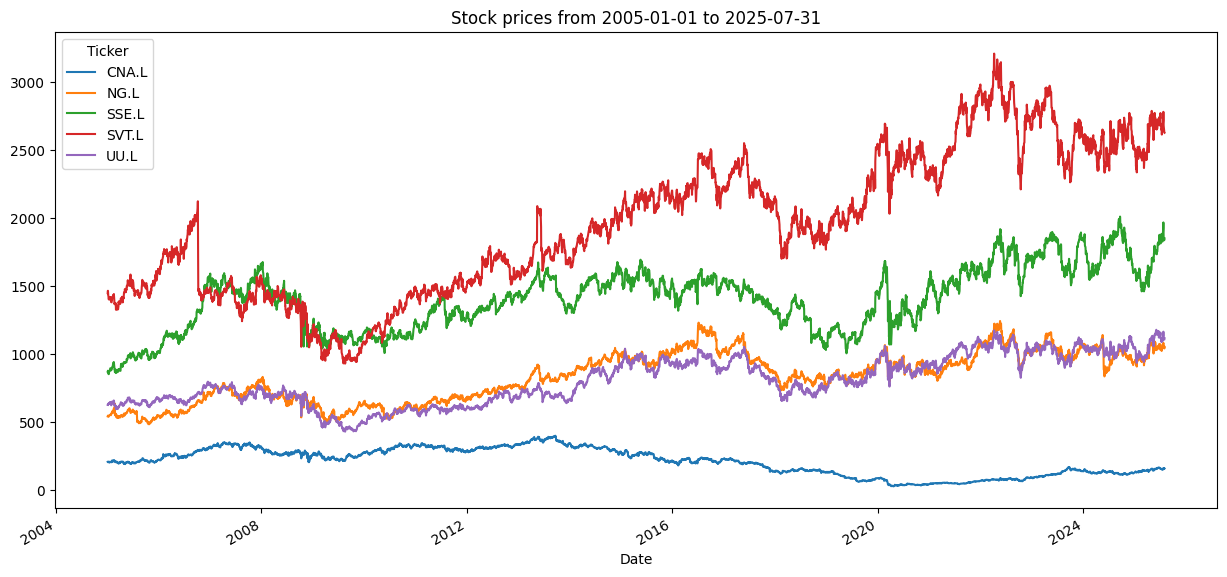

In [14]:
df.plot(figsize=(15,7))
plt.title(f'Stock prices from {START_DATE} to {END_DATE}')
plt.show()

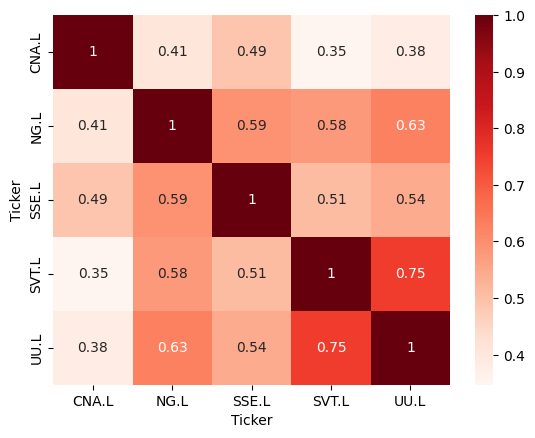

In [15]:
corr_matrix = np.log(df / df.shift(1)).dropna().corr()
sns.heatmap(corr_matrix, cmap='Reds', annot=True)
plt.show()

In [ ]:
def find_cointegrated_pairs(data):
    columns = data.columns
    pairs = itertools.combinations(columns,2)
    coint_pairs = []
    for pair in pairs:
        S1, S2 = pair
        p_value = coint(data[S1],data[S2])[1]
        if p_value < 0.05:
            coint_pairs.append((pair,p_value))
    return coint_pairs

def compute_signals(data,alpha, beta, zscore_window,in_threshold,out_threshold):
    S1, S2 = data.columns.values
    data['spread'] = data[S1] - (alpha + beta * data[S2])
    data['zscore'] = np.nan
    data['signal'] = 0

    # Z-score calculation and signal generation on the test data
    for i in range(zscore_window, len(data)):
        window = data.iloc[i-zscore_window:i]['spread']
        spread_mean = window.mean()
        spread_std = window.std()
        z = (data.iloc[i]['spread'] - spread_mean) / spread_std
        data.loc[data.index[i], 'zscore'] = z

        if z > in_threshold:
            data.loc[data.index[i], 'signal'] = 1
        elif z < -in_threshold:
            data.loc[data.index[i], 'signal'] = -1
        elif abs(z) < out_threshold and data.iloc[i-1]['signal'] != 0:
            data.loc[data.index[i], 'signal'] = 0
    
    return data

def run_strategy(data, beta):
    S1, S2 = data.columns.values[:2]
    count_S1 = 0
    count_S2 = 0
    profit = 0
    trades = 0
    profit_series = pd.Series()
    
    for i in range(1,len(data)):
        if data.iloc[i]['signal'] == 1 and data.iloc[i-1]['signal'] != 1:
            profit += data.iloc[i][S1] - data.iloc[i][S2] * beta
            count_S1 -= 1
            count_S2 += beta
            trades += 1
        elif data.iloc[i]['signal'] == -1 and data.iloc[i-1]['signal'] != -1:
            profit -= data.iloc[i][S1] - data.iloc[i][S2] * beta
            count_S1 += 1
            count_S2 -= beta
            trades += 1
        elif data.iloc[i]['signal'] == 0 and data.iloc[i-1]['signal'] != 0:
            profit += data.iloc[i][S1] * count_S1 + data.iloc[i][S2] * count_S2
            profit_series.loc[data.index[i]] = profit
            count_S1 = 0
            count_S2 = 0
    return profit, trades, profit_series


In [ ]:
def plot_strategy(data, threshold=2.0):

    S1, S2 = data.columns.values[:2]
    
    # --- Zscore Graph ---
    plt.figure(figsize=(14, 6))
    
    sns.lineplot(x=data.index, y=data['zscore'], label='Z-Score')
    
    # Seuils horizontaux
    plt.axhline(threshold, color='red', linestyle='--', alpha=0.7, label=f'+{threshold}')
    plt.axhline(-threshold, color='red', linestyle='--', alpha=0.7, label=f'-{threshold}')
    plt.axhline(0, color='black', linestyle='--', alpha=0.5)
    
    plt.title("Z-Score with thresholds")
    plt.legend()
    plt.show()
    
    # --- Prices Graph ---
    plt.figure(figsize=(14, 6))
    
    sns.lineplot(x=data.index, y=data[S1], label=S1)
    sns.lineplot(x=data.index, y=data[S2], label=S2)
    
    signals = data['signal']
    open_long = (signals.shift(1) == 0) & (signals == 1)
    open_short = (signals.shift(1) == 0) & (signals == -1)
    close_pos = (signals.shift(1).isin([1, -1])) & (signals == 0)
    
    plt.scatter(data.index[open_long], data.loc[open_long, S1], 
                marker='^', color='green', s=100, label=f'Open long {S2} / short {S1}')
    plt.scatter(data.index[open_short], data.loc[open_short, S1], 
                marker='^', color='blue', s=100, label=f'Open long {S1} / short {S2}')
    plt.scatter(data.index[close_pos], data.loc[close_pos, S1], 
                marker='o', color='red', s=80, label='Close position')
    
    plt.title("Stock prices and trading signals")
    plt.legend()
    plt.show()
    
    # --- Spread Graph ---
    plt.figure(figsize=(14, 6))
    
    sns.lineplot(x=data.index, y=data['spread'], label='Spread')
    
    spread_upper = threshold * data['spread'].std()
    spread_lower = -threshold * data['spread'].std()
    
    plt.axhline(spread_upper, color='red', linestyle='--', alpha=0.7, label=f'+{threshold}σ')
    plt.axhline(spread_lower, color='red', linestyle='--', alpha=0.7, label=f'-{threshold}σ')
    plt.axhline(0, color='black', linestyle='--', alpha=0.5)
    
    plt.scatter(data.index[open_long], data.loc[open_long, 'spread'], 
                marker='^', color='green', s=100, label=f'Open position (long {S2} / short {S1})')
    plt.scatter(data.index[open_short], data.loc[open_short, 'spread'], 
                marker='^', color='blue', s=100, label=f'Open position (long {S1} / short {S2})')
    plt.scatter(data.index[close_pos], data.loc[close_pos, 'spread'], 
                marker='o', color='red', s=80, label='Close position')
    
    plt.title("Spread and trading signals")
    plt.legend()
    plt.show()

In [ ]:
def backtest_out_of_sample(data, train_ratio, zscore_window, in_threshold, out_threshold, visualization: bool = False):
    # Split train / test
    train_size = int(train_ratio * len(data))
    train_data = data.iloc[:train_size]
    test_data = data.iloc[train_size:]

    # Find the most cointegrated pair in the train data
    coint_pairs = find_cointegrated_pairs(train_data)
    if not coint_pairs:
        print("No cointegrated pairs found in the train data")
        return None

    highest_coint_pair = min(coint_pairs, key=lambda x: x[1])[0]
    S1, S2 = list(highest_coint_pair)

    # Calculate beta and alpha for the train data
    model = OLS(train_data[S1], add_constant(train_data[S2])).fit()
    alpha, beta = model.params

    test_data = test_data[[S1, S2]].copy()
    test_data = compute_signals(test_data,alpha,beta,zscore_window,in_threshold,out_threshold)

    if visualization:
        plot_strategy(test_data)

    # Run the strategy
    profit, trades, profit_series = run_strategy(test_data, beta)
    return profit, trades, profit_series

    

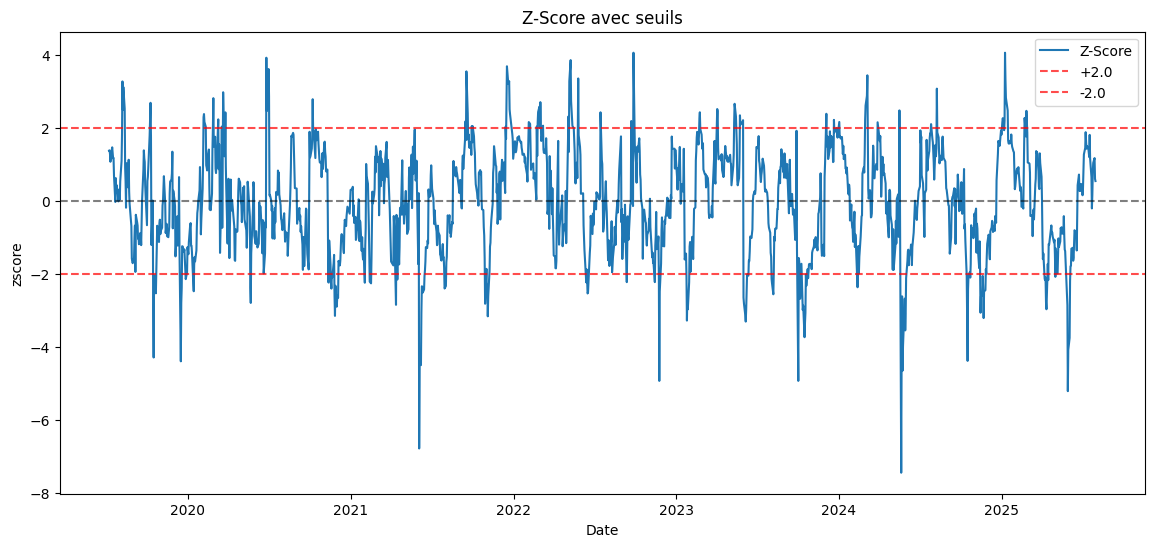

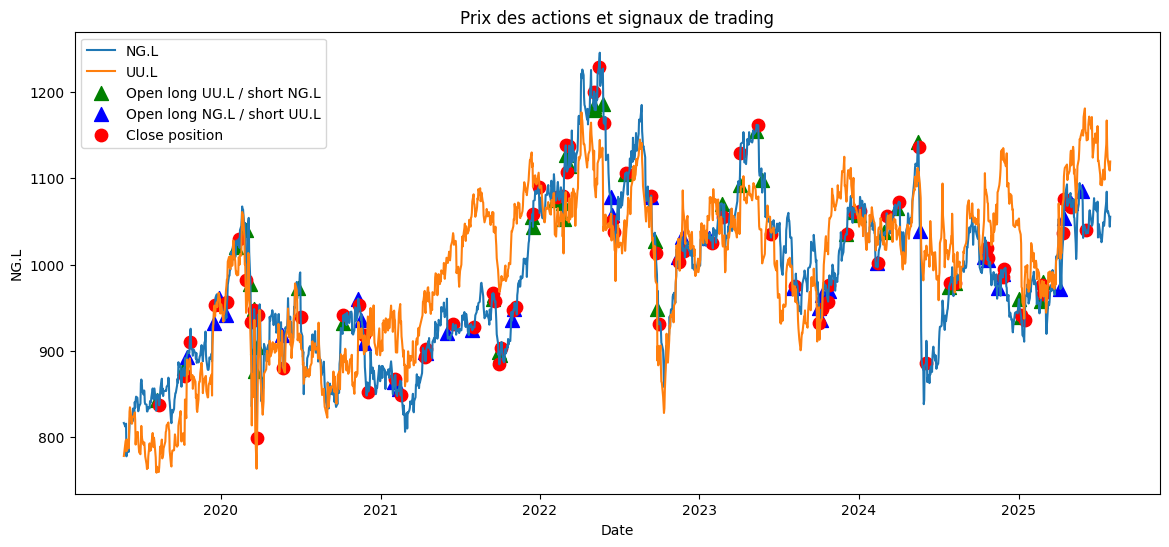

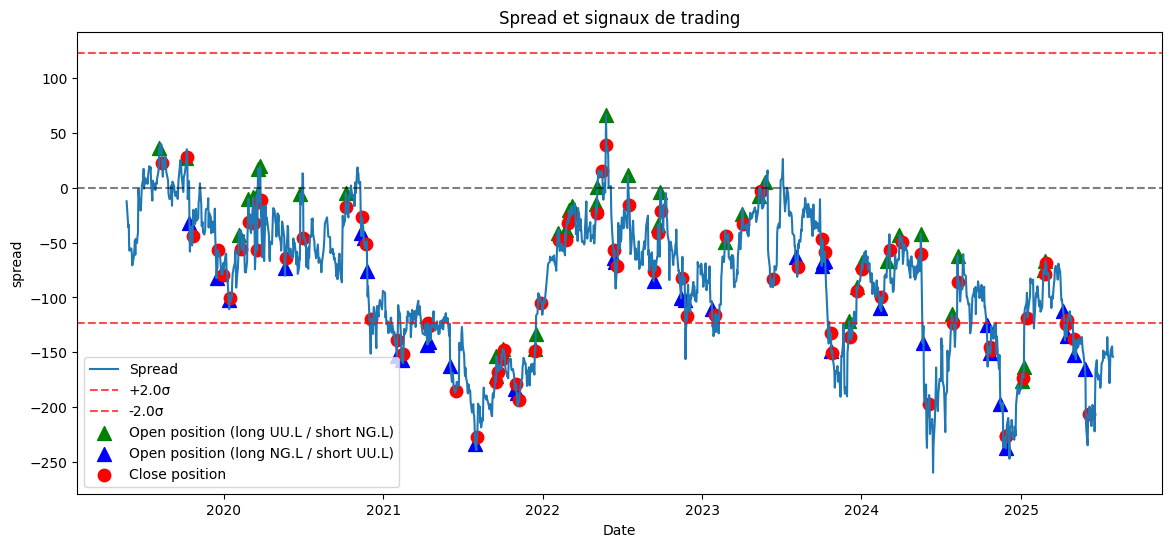

Profit made from the strategy: €304.6675
Number of trades executed: 81


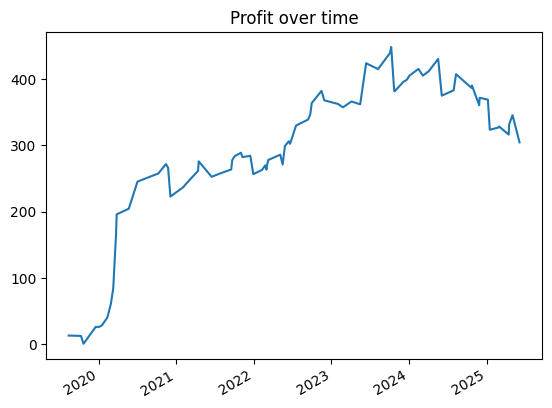

In [20]:
ZSCORE_WINDOW = 30
IN_THRESHOLD = 2
OUT_THRESHOLD = 0.5

profit, trades, profit_series = backtest_out_of_sample(df,0.7,ZSCORE_WINDOW,IN_THRESHOLD,OUT_THRESHOLD, visualization=True)

print(f'Profit made from the strategy: €{profit:,.4f}')
print(f'Number of trades executed: {trades:,.0f}')

profit_series.plot()
plt.title('Profit over time')
plt.show()